In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import cPickle as pickle

slim = tf.contrib.slim

In [2]:
pickle_file = './datasets/2014.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    X_train = save['N_data']
    y_train = save['N_label']
    del save  # hint to help gc free up memory
    print('Training set', X_train.shape, y_train.shape)

('Training set', (105024, 96, 7), (105024, 7))


In [3]:
pickle_file = './datasets/2015.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    X_test = save['N_data']
    y_test = save['N_label']
    del save  # hint to help gc free up memory
    print('Testing set', X_test.shape, y_test.shape)

('Testing set', (105024, 96, 7), (105024, 7))


In [4]:
np.random.seed(133)
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [5]:
shape = (-1,96,7,1)
max_vol = 500

def reshape_normalize(X):
    return X.reshape(shape).astype(np.float32) / max_vol

In [6]:
X_train , y_train = randomize(X_train,y_train)

X_train = reshape_normalize(X_train)
X_test = reshape_normalize(X_test)

y_train = y_train / max_vol
y_test = y_test / max_vol

print X_train.shape
print X_test.shape

(105024, 96, 7, 1)
(105024, 96, 7, 1)


In [7]:
def iter_minibatches(X,y,batch_size=128):
    step = 0
    while True:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_X = X[offset:(offset + batch_size)]
        batch_y = y[offset:(offset + batch_size)]
        
        yield batch_X, batch_y
        step+=1

In [8]:
def cnn_regression(X):
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(X, 16, [3, 3],scope='conv_1')
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [3, 3],scope='conv_2')
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, 7, activation_fn=tf.sigmoid)       
        return net

In [ ]:
data_generator = iter_minibatches(X_train,y_train)

In [ ]:
ckpt_dir = './tmp/regression_model_200_scope/'

with tf.Graph().as_default():
    X_,y_ = data_generator.next()
    
    X_ = tf.constant(X_)
    y_ = tf.constant(y_)
    
    y_hat = cnn_regression(X_)
    loss = slim.losses.mean_squared_error(y_hat, y_)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(loss, optimizer) 
    
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=100,
        save_summaries_secs=5,
        log_every_n_steps=100)
    
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

In [18]:
ckpt_dir = './tmp/regression_model_200_scope/'
with tf.Graph().as_default():
    X_ = tf.constant(X_test)
    y_ = tf.constant(y_test)
  
    y_hat = cnn_regression(X_)
    loss = slim.losses.sum_of_squares(y_hat, y_)
    
    conv_1_vars_op = slim.get_variables(scope='conv_1')
    conv_2_vars_op = slim.get_variables(scope='conv_2')
    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        #y_hat_ , loss_ = sess.run([y_hat , loss])
         y_hat_ ,conv_1_vars,conv_2_vars = sess.run([y_hat,
                                                     conv_1_vars_op,
                                                     conv_2_vars_op])

Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.


In [10]:
kernels = conv_1_vars[0]

In [11]:
kernels[:,:,:,0].reshape((3,3))

array([[ 0.12245128,  0.14335148,  0.11397937],
       [-0.05639681, -0.08912283,  0.08100664],
       [ 0.09439145, -0.15765245, -0.09991849]], dtype=float32)

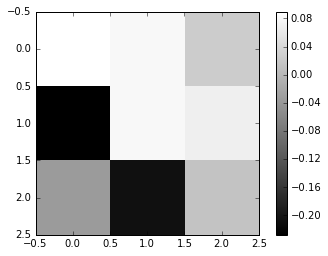

In [27]:
plt.imshow(kernels[:,:,:,6].reshape((3,3)) ,cmap='gray',interpolation='nearest')
plt.colorbar()

In [21]:
conv_2.shape

(3, 3, 16, 64)

In [ ]:
loss_ * max_vol

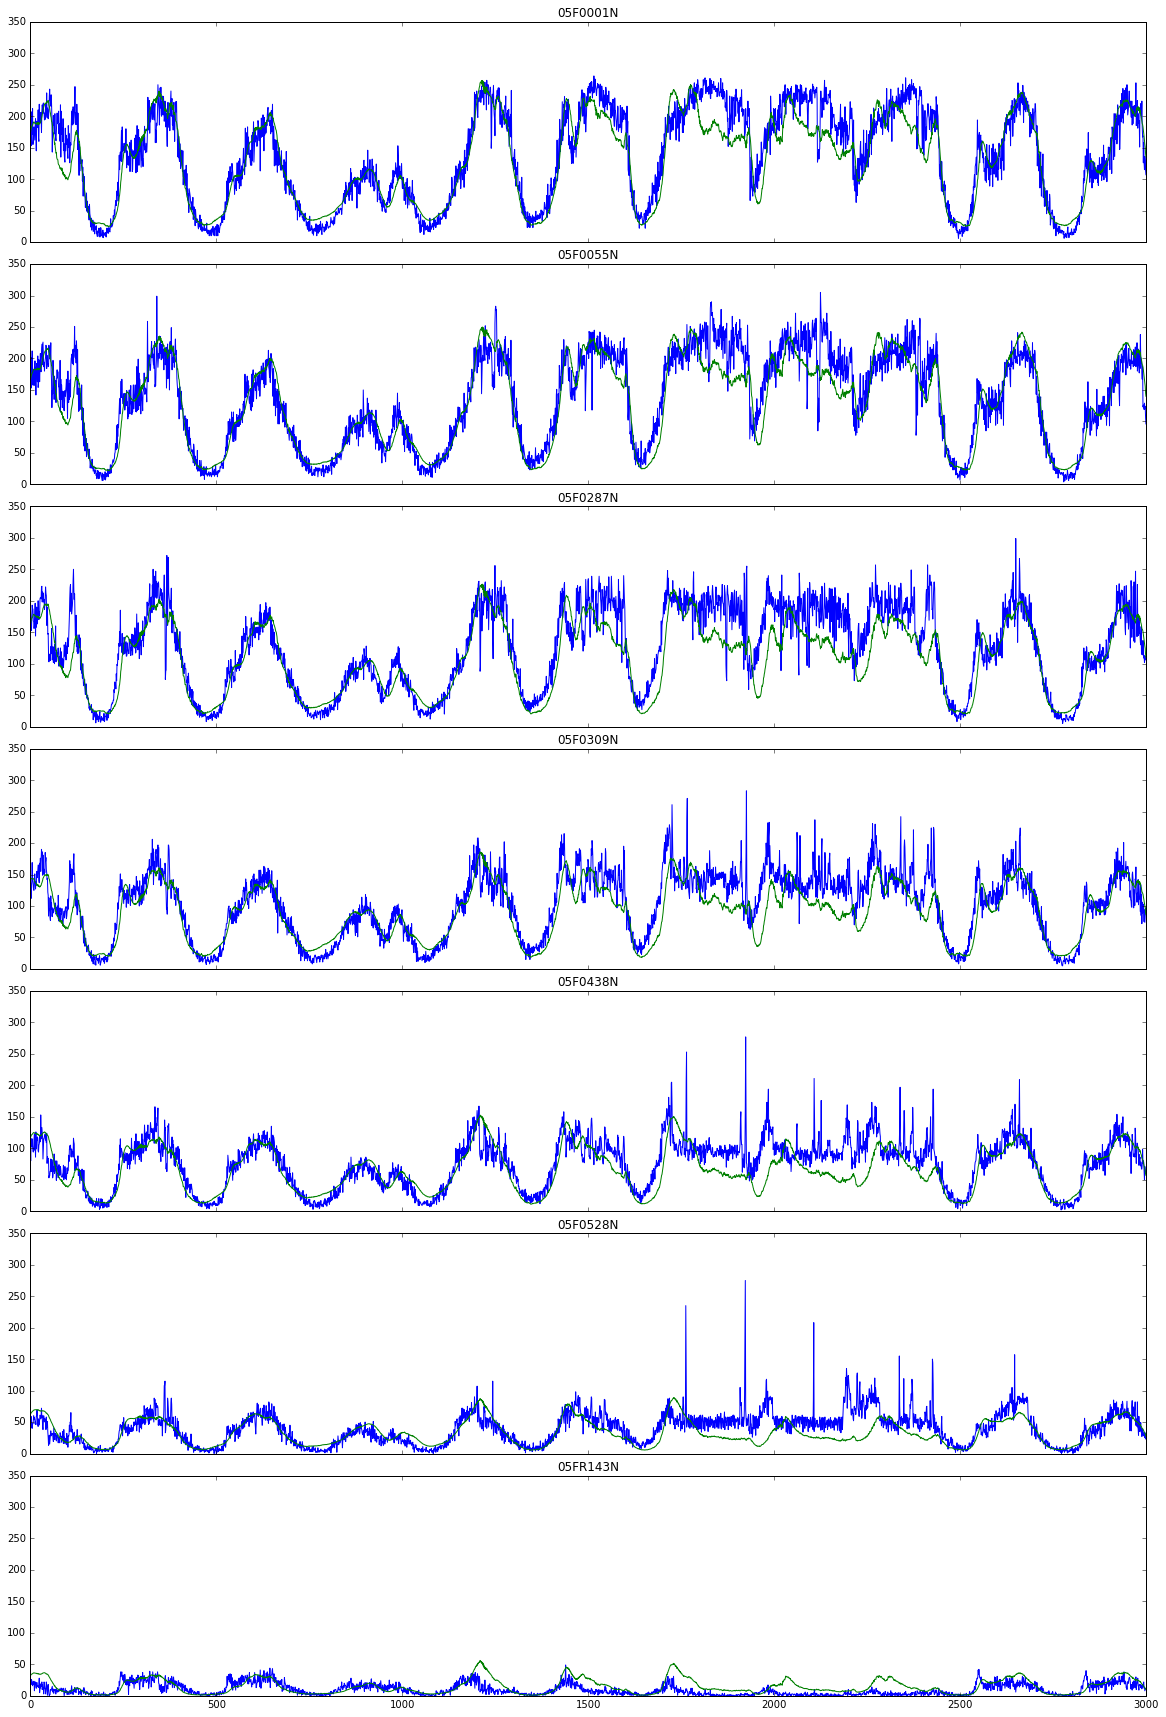

In [34]:
vids = ["05F0001N","05F0055N","05F0287N","05F0309N","05F0438N","05F0528N","05FR143N"]
f, axarr = plt.subplots(7, sharex=True, sharey=True,figsize=(20,30))
for i in range(7):
    axarr[i].plot(y_test[13000:16000,i]*max_vol)
    axarr[i].plot(y_hat_[13000:16000,i]*max_vol)
    axarr[i].set_title(vids[i])

f.subplots_adjust(hspace=0.1)